In [119]:
import numpy as np
import matplotlib.pyplot as plt
import os, re
from math import isclose

In [120]:
run_RE = re.compile("slurm-([0-9]+)(.out|)$")

bs_RE = re.compile(".*Train Buffer Size: 0, training batch size: ([0-9]+)")
ranks_RE = re.compile("ranks [0-9]+ ([0-9]+)")
lrscale_RE = re.compile("lrScaling ([a-zA-Z0-9]+)")
lr_RE = re.compile(".*Skaling learning rate from ([0-9.e+-]+) to ([0-9.e+-]+) due to bs factor ([0-9.e+-]+)")
param_RE = re.compile(".*#Param ([a-zA-Z0-9._]+)= ([a-zA-Z0-9._/-]+)")

runF_RE = re.compile("([0-9]+)-nodes_lr-([0-9.]+)_min-tb-([0-9]+)(?:_lrAE-([0-9]+))?$")

lossDat_RE = re.compile("loss_([0-9]+).dat")


In [145]:
def loadRuns(path="../"):
    runs = {}
    
    for fn in os.listdir(path):
        m = run_RE.match(fn)
        if not m:
            continue

        i = m[1]
        if i in runs:
            run = runs[i]
        else:
            run = {"i": i, "path":path, "nnodes":1}
        
        found = 0
        if m[2] == ".out":
            with open(os.path.join(path, fn)) as f:
                lines = f.readlines()

            ranks = 0
            for l in lines:
                    
                m = ranks_RE.match(l)
                if m:
                    ranks += 1
                    continue
            
                m = lrscale_RE.match(l)
                if m and not "lrscaling" in run:
                    run["lrscaling"] = m[1]
                    found += 1
                    
                m = lr_RE.match(l)
                if m and not "lr" in run:
                    run["lr"] = m[1]
                    run["lrscaled"] = m[2]
                    run["lrfactor"] = m[3]
                    found += 1
                    
                m = param_RE.match(l)
                if m:
                    run[m[1]] = m[2]
                    
            if found < 2:
                if not "lrscaling" in run:
                    run["lrscaling"] = "_"
                    found += 1
                if not "lr" in run:
                    run["lr"] = float("nan")
                    run["lrscaled"] = 1
                    run["lrfactor"] = 1
                    found += 1
            if found < 2:
                    print("[WW] Meta data missign from {} file".format(fn))
                    print(run)
                    continue
            
            if ranks == 0:
                print("[WW] No ranks in run {}".format(fn))

            run["ranks"] = ranks
            
            runs[i] = run
    return runs

In [158]:
def plotLosses(col, runs, title=None, smoothWindow=20, filt=None):
    li = list(runs.keys())
    li.sort()
    for i in li:
        r = runs[i]
        
        if filt is not None:
            for f in filt:
                if f[0] not in r:
                    print("Ignoring filter for non-present property:", f[0])
                    continue
                if r[f[0]] not in f[1]:
                    r = None
                    break
            if r is None:
                continue
        
        i = r["i"]
        if not "dat" in r:
            r["dat"] = np.loadtxt("{}/slurm-{}/loss_0.dat".format(r["path"], i))
        dat = r["dat"]
        #print(i, dat.shape)
        if "lrscale" in r:
            lrscale = r["lrscale"]
        else:
            lrscale = "1"
        linestyle = "-"
        if lrscale == "sqrt":
            linestyle = ":"
        if "lr" in r:
            lr = r["lr"]
            lrscaled = r["lrscaled"]
        else:
            lr = "nan"
            lrscaled = "nan"
            
        if "type_streamer" in r:
            if r["type_streamer"] == "streaming":
                linestyle = "-"
                
        smooth = np.convolve(dat[:, col], np.ones(smoothWindow)/smoothWindow, mode='valid')
        d = (dat.shape[0] - smooth.shape[0] ) // 2
        lrAEmult = r.get("config.lrAEmult", 1)
        
        rep = r.get("trainBatchBuffer_config.min_tb_from_unchanged_now_bf", 0)
        if rep == "8":
            linestyle = ":"
        #print(rep, linestyle)
        
        if int(lrAEmult) == 1:
            linestyle = ":"

        plt.plot(dat[d:-d-1, 0], smooth,
                 label=("{}: r{} bs{} lr{}->{} lrAEmult{}".format(i, r["ranks"], "_", lr, lrscaled, lrAEmult)),
                 ls=linestyle)
    if title is None:
        plt.title(f"col {col}")
    else:
        plt.title(title)
    #plt.ylim((0,10))
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    #plt.legend()
    

In [159]:
path="/bigdata/hplsim/scratch/kelling//oldBSruns/"
path="/bigdata/hplsim/scratch/kelling//fixedBSruns/"
path="/bigdata/hplsim/scratch/kelling//scaledlrRuns/"

path="/bigdata/hplsim/scratch/kelling/chamfers/lrAE"
path="../"

runs = loadRuns(path)
#runs2 = loadRuns("../runs_CL")
#runs.update(runs2)

#runs = loadRuns(path)
runs2 = loadRuns("/bigdata/hplsim/scratch/kelling/chamfers/")
runs.update(runs2)

In [160]:
#("config.lrAEmult", (5,20,40,80,100,150,200,600,800,1000))
filt = [("trainBatchBuffer_config.min_tb_from_unchanged_now_bf", ("4",)), ("config.lrAEmult", ("15","20","25"))]

(0.0, 4.0)

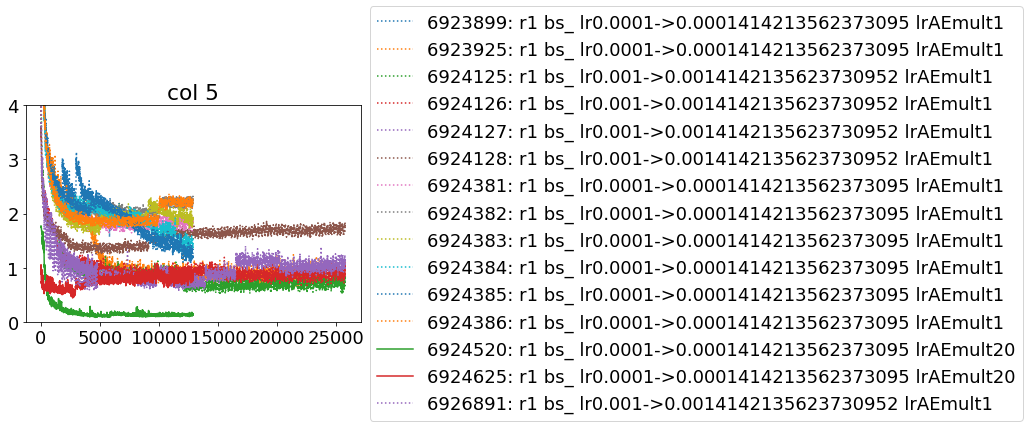

In [161]:
plotLosses(5, runs, smoothWindow=20, filt=None)
plt.ylim((0,4))

Ignoring filter for non-present property: trainBatchBuffer_config.min_tb_from_unchanged_now_bf
Ignoring filter for non-present property: config.lrAEmult
Ignoring filter for non-present property: config.lrAEmult


(1.0, 5.0)

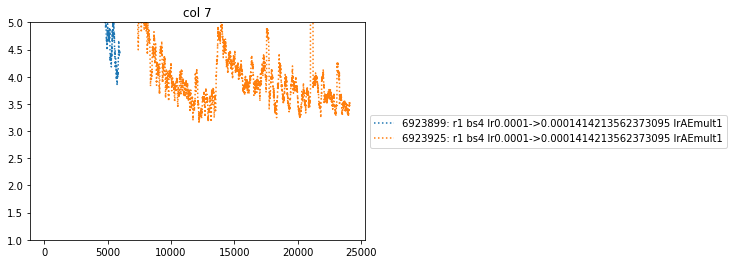

In [23]:
plotLosses(7, runs, smoothWindow=200, filt=filt)
plt.ylim((1,5))
#plt.xlim((0,6000))

Ignoring filter for non-present property: trainBatchBuffer_config.min_tb_from_unchanged_now_bf
Ignoring filter for non-present property: config.lrAEmult
Ignoring filter for non-present property: config.lrAEmult


(256.0, 258.0)

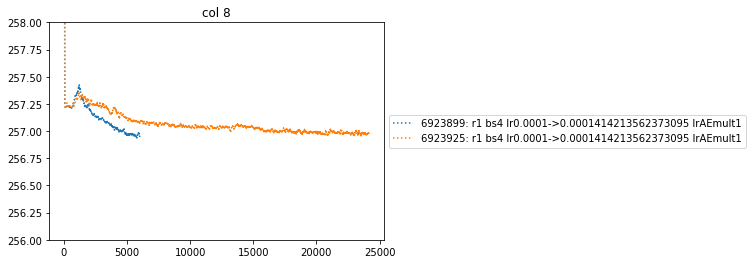

In [24]:
plotLosses(8, runs, smoothWindow=100, filt=filt)
#plt.ylim((440,460))
plt.ylim((256,258))

Ignoring filter for non-present property: trainBatchBuffer_config.min_tb_from_unchanged_now_bf
Ignoring filter for non-present property: config.lrAEmult
Ignoring filter for non-present property: config.lrAEmult
Ignoring filter for non-present property: config.lrAEmult


(345.0, 346.0)

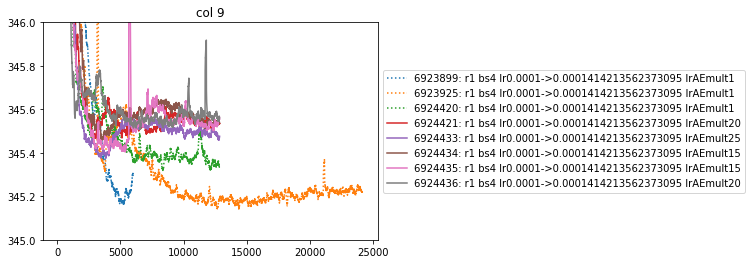

In [10]:
plotLosses(9, runs, smoothWindow=100, filt=filt)
#plt.ylim((302.7,390))
plt.ylim((345,346))

In [11]:
for r in runs.values():
    dat = r["dat"]
    print(r["i"], r["ranks"], r["bs"], np.mean(dat[10:,1]))

KeyError: 'dat'

In [74]:
def loadRun(i, path):
    
    gpath = os.path.join(path, "training.out")
    if not os.path.isfile(gpath):
        gpath = os.path.join(path, "out.txt")
        if not os.path.isfile(gpath):
            raise RuntimeError("the path '{}' does not appear to be a training run.".format(path))
            
    with open(gpath) as f:
        lines = f.readlines()
        
    run = {"i": i, "path": path}

    ranks = 0
    for l in lines:
        m = bs_RE.match(l)
        if m and not "bs" in run:
            run["bs"] = int(m[1])

        lr_RE = re.compile(".*Skaling learning rate from ([0-9.e+-]+) to ([0-9.e+-]+) due to bs factor ([0-9.e+-]+)")
        m = lr_RE.match(l)

        if m:
            if "lr" in run and not isclose(float(m[1]), run["lr"]):
                print("[WW] loss info in file path and training.out mismatch.")
            run["lr"] = float(m[1])
            run["lrscaled"] = float(m[2])
            run["lrfactor"] = float(m[3])

        m = param_RE.match(l)
        if m:
            run[m[1]] = m[2]
            
        m = ranks_RE.match(l)
        if m:
            ranks += 1

    run["ranks"] = ranks

    return run

In [25]:
def loadRunsF(path="/bigdata/hplsim/aipp/SC24_PIConGPU-Continual-Learning/03-30_learning-rate-scaling-with-ranks_chamfersdistance_fix-gpu-volume"):
    runs = {}
    
    for fn in os.listdir(path):
        mf = runF_RE.match(fn)
        if mf is None:
            continue
        
        subruns = []
        gpath = os.path.join(path, fn)
        if os.path.isfile(os.path.join(gpath, "training.out")):
            subruns.append((gpath,fn))
        else:
            for fnr in os.listdir(gpath):
                ipath = os.path.join(gpath, fnr)
                if os.path.isdir(ipath) and os.path.isfile(os.path.join(ipath, "training.out")):
                    subruns.append((ipath, os.path.join(fn,fnr)))
   
        for gpath, i in subruns:

            run = {"rep":int(mf[3]), "lr":float(mf[2]), "nnodes":int(mf[1])}
                
            run.update(loadRun(i, gpath))
            
            runs[i] = run
    return runs

In [166]:
def loadDat(path):
    dats = []
    n = 0
    datdir = os.path.join(path, "simOutput")
    if not os.path.isdir(datdir):
        datdir = path
    for fn in os.listdir(datdir):
        m = lossDat_RE.match(fn)
        if not m:
            continue
        fpath = os.path.join(datdir, fn)
        dat = np.loadtxt(fpath)
        dats.append(dat)
    
    l = min(d.shape[0] for d in dats)
    dats = np.stack(d[:l] for d in dats)
    
    return np.mean(dats, axis=0), np.std(dats, axis=0), dats

def filtDict(d, filt):
    ret = {}
    for i, r in d.items():
        for f in filt:
            if f[0] not in r:
                print("Ignoring filter for non-present property:", f[0])
                continue
            if r[f[0]] not in f[1]:
                r = None
                break
        if r is not None:
            ret[i] = r
    
    return ret

def plotLossesF(col, runs, title=None, smoothWindow=20, filt=None):
    li = list(runs.keys())
    li.sort()
    for i in li:
        r = runs[i]

        if filt is not None:
            for f in filt:
                if f[0] not in r:
                    print("Ignoring filter for non-present property:", f[0])
                    continue
                if r[f[0]] not in f[1]:
                    r = None
                    break
            if r is None:
                continue

        i = r["i"]
        
        if "dat" not in r:
            r["dat"], r["datStdev"], r["dats"] = loadDat(r["path"])
            
            
        dat = r["dat"]
        #print(i, dat.shape)
        if "lrscale" in r:
            lrscale = r["lrscale"]
        else:
            lrscale = "1"
        linestyle = "-"
        if lrscale == "sqrt":
            linestyle = ":"
        if "lr" in r:
            lr = r["lr"]
            lrscaled = r["lrscaled"]
        else:
            lr = "nan"
            lrscaled = "nan"
            
        nnodes = r.get("nnodes", 1)
            
        if nnodes == 48:
            linestyle = "-."
        elif nnodes == 24:
            linestyle = "--"
        elif nnodes == 72:
            linestyle = "-"
        elif nnodes == 96:
            linestyle = ":"
        smooth = np.convolve(dat[:, col], np.ones(smoothWindow)/smoothWindow, mode='valid')
        d = (dat.shape[0] - smooth.shape[0] ) // 2
        rep = r.get("trainBatchBuffer_config.min_tb_from_unchanged_now_bf", 0)
        if rep == 8:
            linestyle = ";"
        plt.plot(dat[d:-d-1, 0], smooth,
                 label=("{}: r{} bs{} lr{}->{} rep{}".format(i, r["ranks"], "_", lr, lrscaled, rep)),
                 ls=linestyle)
    if title is None:
        plt.title(f"col {col}")
    else:
        plt.title(title)
    #plt.ylim((0,10))
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    #plt.legend()
    

In [162]:
runsh = runs

In [132]:
path = "/bigdata/hplsim/aipp/SC24_PIConGPU-Continual-Learning/03-31_independent-AE-scaling_chamfersdistance_fix-gpu-volume_scaling"
path = "/bigdata/hplsim/aipp/SC24_PIConGPU-Continual-Learning/03-30_learning-rate-scaling-with-ranks_chamfersdistance_fix-gpu-volume"
#path = "/bigdata/hplsim/aipp/SC24_PIConGPU-Continual-Learning/04-01_rerun-independent-AE-scaling_chamfersdistance_fix-gpu-volume_scaling/"
runs = loadRunsF(path)
#runs.update(runs2)

In [75]:
filt = [("rep", (16,)), ("lr", (.0001,))]
#filt = [("nnodes", (96,))]
filt=None
runsf = runs #filtDict(runs, filt)

In [163]:
runs = {"hemera": loadRun("hemera", "/bigdata/hplsim/aipp/SC24_PIConGPU-Continual-Learning/04-02_single-gpu-offline-training-from-24-node_hemera/trainingOutput")}
runs["frontier"] = loadRun("frontier", "/bigdata/hplsim/aipp/SC24_PIConGPU-Continual-Learning/04-02_single-gpu-offline-training-from-24-node_hemera/trainingOutput")

In [164]:
print(list(runsh.keys()))
for i in ['6923925', '6926891']:
    runs[i] = runsh[i]

['6924125', '6924386', '6924520', '6924625', '6924383', '6924127', '6926891', '6924382', '6924128', '6924381', '6924126', '6924384', '6924385', '6923925', '6923899']


/tmp/ipykernel_40107/3873737855.py:1: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  plotLossesF(5, runs, smoothWindow=20, filt=None)


(0.0, 5.0)

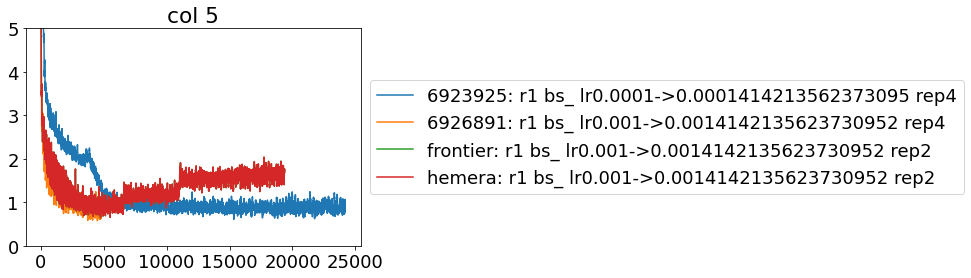

In [168]:
plotLossesF(5, runs, smoothWindow=20, filt=None)
plt.ylim((0,5))

(0.0, 10.0)

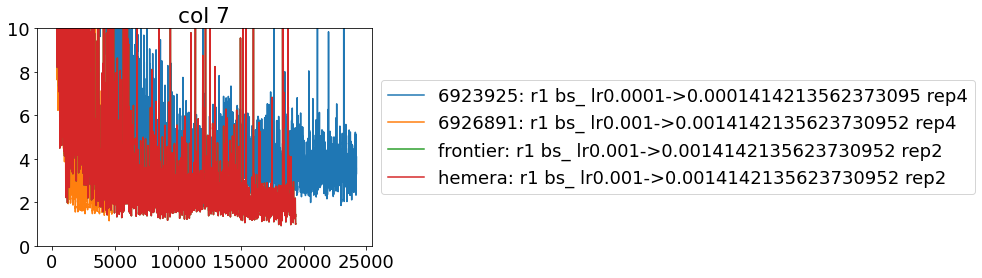

In [172]:
plotLossesF(7, runs, smoothWindow=10, filt=None)
plt.ylim((0,10))

(225.0, 327.0)

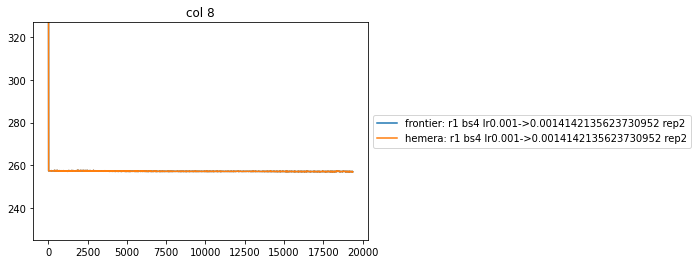

In [69]:
plotLossesF(8, runs, smoothWindow=10, filt=filt)
plt.ylim((225,327))

(302.0, 304.0)

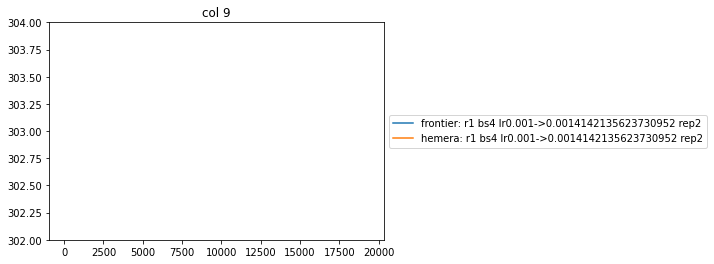

In [65]:
plotLossesF(9, runs, smoothWindow=20, filt=filt)
plt.ylim((302,304))

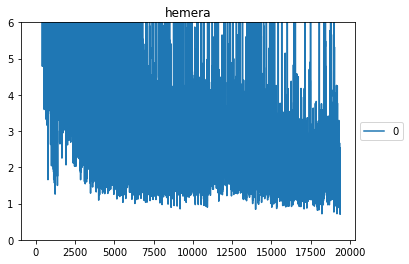

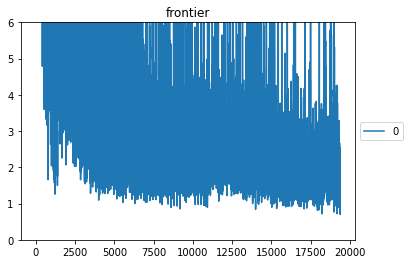

In [66]:
runsf = runs #filtDict(runs, filt)
col = 7
for r in runsf.values():
    plt.title(r["i"])
    dats = r["dats"]
    for d in range(dats.shape[0]):
        if d not in [0,3,4,7,8]:
        #if d not in [1,2,5,6,9]:
            pass
        plt.plot(dats[d, :, 0], dats[d, :, col], label=str(d))

    plt.ylim(0,6)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()

In [67]:
runss = {}

def dcp(k, a = runss, b = runsf):
    a[k] = b[k]

idstr = "{}-nodes_lr-{}_min-tb-{}"
dcp(idstr.format(96, "0.0005", 16))
dcp(idstr.format(96, "0.0001", 16))
dcp(idstr.format(96, "0.0005", 8))

dcp(idstr.format(24, "0.0001", 16))
dcp(idstr.format(24, "0.0001", 8))
dcp(idstr.format(24, "0.0001", 4))

KeyError: '96-nodes_lr-0.0005_min-tb-16'

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(0.0, 5.0)

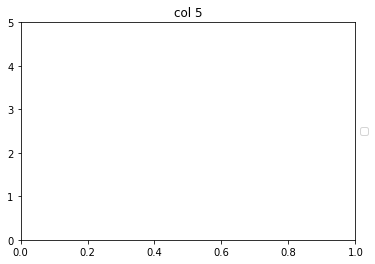

In [117]:


plotLossesF(5, runss, smoothWindow=20, filt=None)
plt.ylim((0,5))

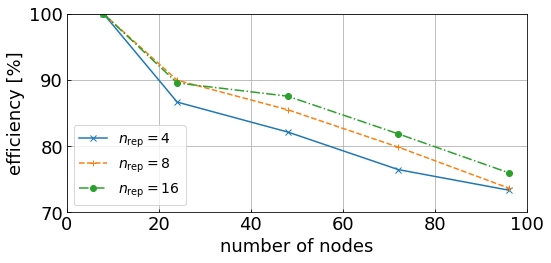

In [96]:
plt.figure(figsize=(8,4))

perf = {}
for r in runs.values():
    if "dat" not in r:
        r["dat"], r["datStdev"] = loadDat(r["path"])
    dat = r["dat"][:, 1]
    
    #i = "lr{} rep{}".format(r["lr"], r["rep"])
    i = int(r["rep"])
    if i not in perf:
        perf[i] = {}
    if r["nnodes"] not in perf[i]:
        perf[i][r["nnodes"]] = []
    perf[i][r["nnodes"]].append(dat)
    
for i in perf:
    r = perf[i]
    for n in r:
        dat = np.concatenate(r[n])
        mean = np.mean(dat)
        std = np.std(dat)
        dat = dat[np.argwhere(np.abs(dat - mean)/std < 4.)]
        mean = np.mean(dat)
        std = np.std(dat)
        r[n] = (mean, std)
        
    d = np.column_stack([np.array(list(r.keys())), np.array(list(r.values()))])
    arg = np.argsort(d[:,0])
    perf[i] = d[arg]

srt = list(perf.keys())
srt.sort()
    
for i in srt:
    r = perf[i]
    #print(r)
    r[:, 1] = r[0, 1] / r[:, 1]
    
    rep = i
    if rep == 4:
        style = dict(marker='x', linestyle='-')
    elif rep == 8:
        style = dict(marker='+', linestyle='--')
    elif rep == 16:
        style = dict(marker='o', linestyle='-.')
    
    #plt.errorbar(perf[i][0][:,0], perf[i][0][:,1], yerr=perf[i][0][:,2], label=i, **style)
    plt.ylim(70,100)
    plt.xlim(0,100)
    plt.plot(r[:, 0], r[:,1]*100, label='$n_\mathrm{{rep}} = {}$'.format(i), **style)
    #t = r["dat"]
    
plt.rcParams.update({'font.size': 18})

plt.tick_params(direction="in")
plt.grid()
plt.xlabel("number of nodes")
plt.ylabel("efficiency [%]")
plt.legend(loc='lower left', fontsize="14")
plt.tight_layout()
plt.savefig("crusher_training_weak-scaling.pdf")

In [149]:
runs['24-nodes_lr-0.001_min-tb-8']["dat"]

array([[0.00000000e+00, 3.78970833e+04, 1.95163391e+05, ...,
        2.87239707e+02, 4.52015858e+02, 1.95153420e+08],
       [1.00000000e+00, 1.02370833e+03, 1.16398800e+14, ...,
        4.75706005e+07, 4.51748146e+02, 1.16398793e+17],
       [2.00000000e+00, 1.90875000e+02, 7.99124849e+13, ...,
        3.46634638e+06, 4.51611824e+02, 7.99124806e+16],
       ...,
       [7.06000000e+02, 2.03500000e+02, 1.94916027e+01, ...,
        2.15351226e+03, 2.26023494e+02, 1.19432065e+04],
       [7.07000000e+02, 2.75583333e+02, 5.83722703e+06, ...,
        2.13856182e+03, 2.25990803e+02, 5.83721924e+09],
       [7.08000000e+02, 2.30083333e+02, 3.80270776e+01, ...,
        2.78544253e+03, 2.26016216e+02, 2.99347391e+04]])

In [228]:
ar = np.array([8,24,48,72,96.]*3)
ar = np.reshape(ar, (3, ar.shape[0]//3))
print(ar)
l = []
for i in range(ar.shape[1]):
    d = ar[0, i]
    dat = np.loadtxt("/home/kelling/checkout/FWKT/InSituML/main/ModelHelpers/cINN/pic/{}_timesteps_averages.dat".format(int(d)))
    t = dat[:,2:]
    print(t.shape)
    mean = np.mean(t, axis=1)
    std = np.std(t, axis=1)
    #print(np.argwhere(np.abs(dat - mean)/std < 4.))
    #print(dat.shape, mean.shape)
    #dat = dat[np.argwhere(np.abs(dat.T - mean)/std < 4.)]
    #print(dat)
    #mean = np.mean(dat, axis=1)
    #std = np.std(dat, axis=1)
    print(mean.shape)
    l.append(mean)
    #ar[1, i] = mean
    #ar[2, i] = std
    break
print(ar)

[[ 8. 24. 48. 72. 96.]
 [ 8. 24. 48. 72. 96.]
 [ 8. 24. 48. 72. 96.]]
(18, 9)
(18,)
[[ 8. 24. 48. 72. 96.]
 [ 8. 24. 48. 72. 96.]
 [ 8. 24. 48. 72. 96.]]


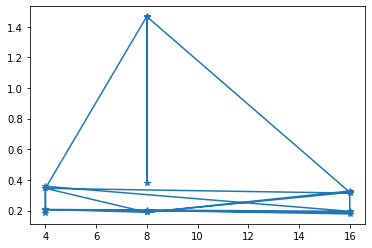

In [230]:
plt.plot(dat[:, 1], mean, marker="*")

In [217]:
l

[array([[0.406 , 0.319 , 0.322 , ..., 0.298 , 0.327 , 0.303 ],
        [0.3165, 0.2615, 0.248 , ..., 0.246 , 0.2555, 0.2365],
        [0.3065, 0.332 , 0.3105, ..., 0.2915, 0.342 , 0.3385],
        ...,
        [0.2355, 0.284 , 0.2825, ..., 0.32  , 0.281 , 0.245 ],
        [0.235 , 0.386 , 0.3285, ..., 0.423 , 0.33  , 0.3595],
        [0.1955, 0.269 , 0.275 , ..., 0.3195, 0.289 , 0.2445]]),
 array([[0.957 , 0.237 , 0.246 , ..., 0.251 , 0.248 , 0.217 ],
        [0.6815, 0.278 , 0.284 , ..., 0.2745, 0.2875, 0.26  ],
        [0.7105, 0.324 , 0.3145, ..., 0.2985, 0.34  , 0.2955],
        ...,
        [0.223 , 0.3685, 0.2905, ..., 0.355 , 0.32  , 0.3965],
        [0.1835, 0.2515, 0.237 , ..., 0.2515, 0.279 , 0.2815],
        [0.3245, 0.359 , 0.3395, ..., 0.3385, 0.441 , 0.391 ]]),
 array([[ 0.406 ,  0.319 ,  0.322 ,  0.339 ,  0.325 ,  0.31  ,  0.298 ,
          0.327 ,  0.303 ],
        [ 0.3065,  0.332 ,  0.3105,  0.377 ,  0.3735,  0.356 ,  0.2915,
          0.342 ,  0.3385],
        [ 0.38

In [177]:
l = np.load("picks.npz")

In [178]:
l

In [179]:
list(l.keys())

['pickPxGen', 'pickPxGT', 'pickRadPred', 'pickRadGT']